# LSE Machine Learning: Practical Applications

## Module 8 Unit 2 IDE Activity (Practice)

### In this IDE activity, K-means and hierarchical clustering is executed on the MovieLens data set in R.

As you complete this activity, you are required to read the text cells throughout the notebook and then run the code in the cells that follow. Be mindful of the syntax used to execute certain functionalities within R to produce a desired result. In completing this activity, you should gain the necessary practical skills to complete the IDE Activity (Assessment) that follows.

### Step 1: Load and install the relevant packages

In [1]:
library(tidyverse)
library(ggplot2)
library(cluster)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Recall from previous modules that the `tidyverse` library is for data preparation. The `ggplot2` library is used for producing nicer plots, so is perhaps not absolutely necessary here.  

### Step 2: Load and prepare the data 

Load the data sets. In this example, the MovieLens data set is used, specifically the movies file and the ratings file. The movies file describes the movie and its genre, whereas the ratings file sets out the ratings for each of the movies, from 0.5 to 5.

In [2]:
# Load the movies data set
movies <- read.csv("movies.csv", header = T)
# Load the ratings data set
ratings <- read.csv("ratings.csv", header = T)

Examine the data by assessing the number of rows of each of the two data sets by making use of the `dim()` function. 

In [3]:
# Number of movies
dim(movies)

[1] 9742    3

In [4]:
# Number of ratings
dim(ratings)

[1] 100836      4

This data set consists of 9742 movies, and slightly more than 100,000 ratings.

Another important consideration is the number of customers that have submitted a rating. To determine this, use the `length(unique())` function. 

In [5]:
length(unique(ratings$userId))

[1] 610

This output shows that only 610 raters have submitted the total of 100,836 ratings. Next, assess the distribution of these ratings per customer. Use the `%>%` command to chain arguments together. This function is part of the tidyverse package. Use the `ratings` dataset, and group together each user ID with the `group_by` function. Then, count the number of ratings per user with the `count` function. Finally, summarise the data using the `summary` function to gain insight into the number of ratings per customer. 

In [6]:
ratings_per_user <- ratings %>% 
                      group_by(userId) %>% 
                      count() 
summary(ratings_per_user$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   20.0    35.0    70.5   165.3   168.0  2698.0 

The mean of ratings is 165 per person, whilst perhaps as an outlier, a single person has submitted 2,698 ratings.

To demonstrate the idea of clustering, we start the process by looking at the average rating for each user on Drama and Comedy. The reason we only pick two genres is to facilitate visualisation at a later stage, though the same idea applies to the analysis on all types of movies. To do this, conduct some basic data manipulation processes. Start by merging the `ratings` file and the `movies` file into one data set. 

Merge `ratings` and `movies` together, based on the `movieId` column that they have in common.

In [7]:
movies_and_ratings <- merge(ratings,
                            movies,
                            by.x = "movieId",
                            by.y = "movieId", 
                            all.x = TRUE)

In [8]:
head(movies_and_ratings)

,movieId,userId,rating,timestamp,title,genres
,<int>,<int>,<dbl>,<int>,<fct>,<fct>
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,1,555,4.0,978746159,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,1,232,3.5,1076955621,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,1,590,4.0,1258420408,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,1,601,4.0,1521467801,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6,1,179,4.0,852114051,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Now, the data have both the movie title and the genre apended next to the movie ID and the user ID. 

In [9]:
rsf  <- movies_and_ratings %>% 
        group_by(userId) %>% 
        summarise(Drama = mean(rating[grepl("Drama", genres)]),
                  Comedy = mean(rating[grepl("Comedy", genres)]))

In this code cell, the movies_and_ratings data set is used to `group_by` each user. The `summarise` function then summarises the function that is used, and appends it to each user in the `group_by` statement. To give more details, the `grepl` function inside is applied to search for any mention of the words "Drama" or "Comedy" in the genres. Wrapping this around a `mean` function provides the mean for each user submitted rating for movies of these genres. Before continuing, let's plot the results. 

Warning message:
“Removed 1 rows containing missing values (geom_point).”


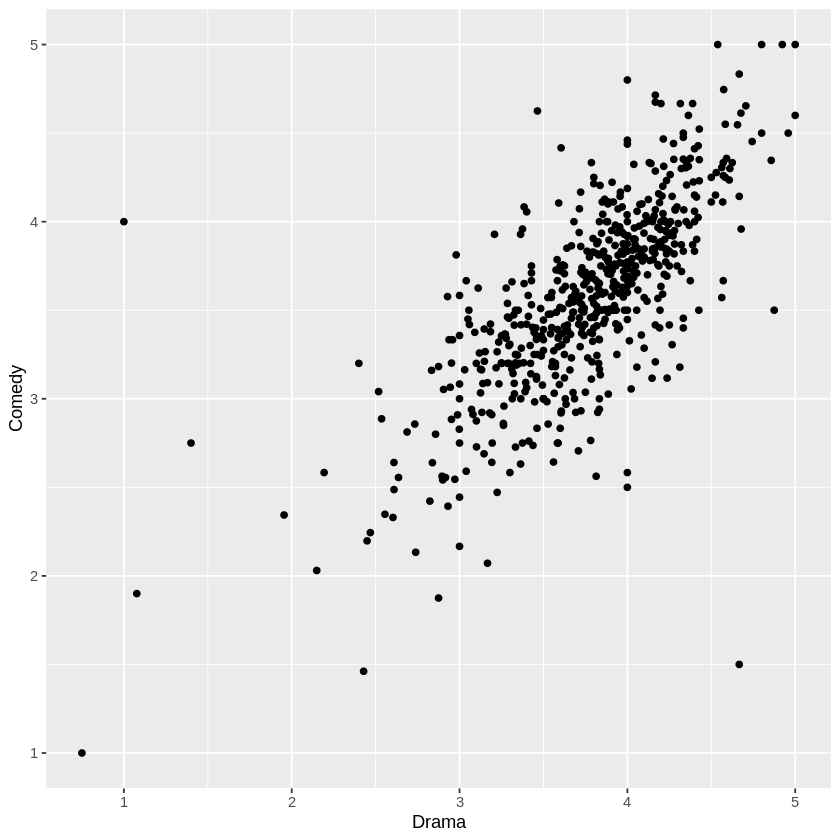

In [10]:
ggplot(rsf) + geom_point(aes(x = Drama, y = Comedy))

Here, each dot represents a user. Their average rating for Drama movies is plotted on the x-axis, while Comedy is on the y-axis.  It appears that there is a tendency for some people to enjoy both Drama and Comedy, and for some people to enjoy neither of them. With this in mind, run a k-means clustering model on the data.
Importantly, the k-means algorithm doesn't work well with missing values where there is a user who hasn't viewed any Drama or Comedy films, so for now, let's remove these values from the data. Use the `drop_na` function to remove these values. Also, the `select()` function selects columns from the data frame. Here we remove the userID variable using negative selection.

In [11]:
rsf_2 <- rsf %>% drop_na() %>% select(-userId)

### Step 3: Applying K-means

Now the k-means model can be fitted on the data set. The `kmeans` function is contained in base R, therefore there is no need to load an additional package into R to execute this function.


In [12]:
kmeans_model_1 <- kmeans(rsf_2, 2)

The k-means algorithm is run by calling the `kmeans` function in R. Provide two parameters - the data and the number of clusters. For this example, two clusters are chosen. As explained before, the outcome of k-means would depend on the positions of the initial centroids, so when rerunning the code, sometimes it is possible for you to see a slightly different result, especially when k is large. Here, the `mutate()` function adds a column to the data set, adding the cluster to which each row belongs, which was output from the k-means model. 

In [13]:
rsf_3 <- rsf_2 %>% 
         mutate(cluster =  as.factor(kmeans_model_1$cluster))

Plot the model using the `ggplot()` function.

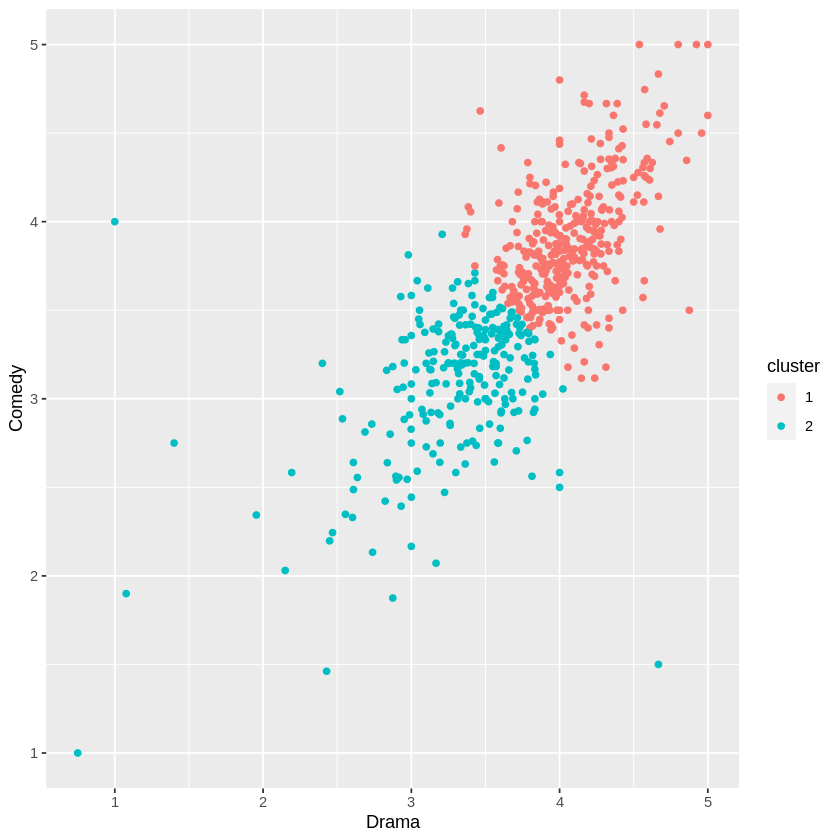

In [14]:
ggplot(rsf_3) + geom_point(aes(x = Drama, y = Comedy, color = cluster))

The model has performed well to predict two distinct clusters. Cluster 1 appears to be individuals who like both types of movies, whilst cluster 2 appears to be those that typically like neither. 

Now consider the properties of each cluster. Group each cluster using the `group_by` function, and summarise the data based on the given function with the `summarise` function. In this case, the given function is the minimum (`min`), mean (`mean`), and maximum (`max`) scores for average Drama and Comedy ratings for each of the clusters.

In [15]:
rsf_3 %>% 
  group_by(cluster) %>%
  summarise(min(Drama),
            mean(Drama),
            max(Drama),
            min(Comedy),
            mean(Comedy),
            max(Comedy))

,cluster,min(Drama),mean(Drama),max(Drama),min(Comedy),mean(Comedy),max(Comedy)
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3.363636,4.069893,5.000000,3.116071,3.896936,5
2,2,0.750000,3.299658,4.666667,1.000000,3.088953,4


From the output, it appears that the minimum scores for both types of movie average ratings are much lower than in one cluster than the other. The same conclusion holds for the mean and maximum scores.

Next, try three clusters using similar steps as before. 

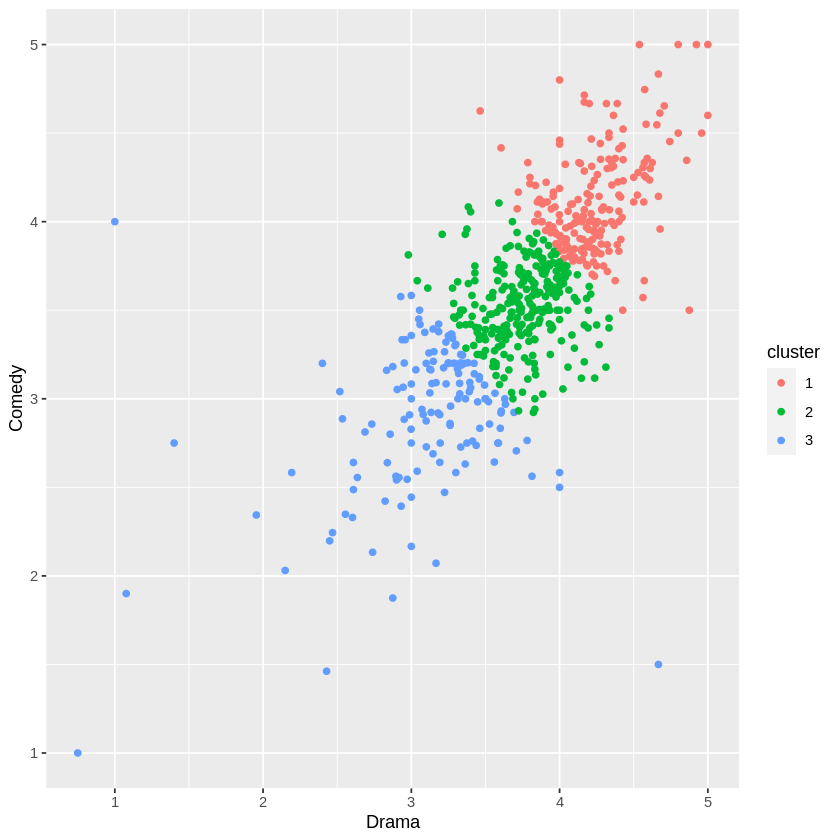

In [16]:
kmeans_model_2 <- kmeans(rsf_2, 3)
# Put the estimate back
rsf_4 <- rsf_2 %>% 
          mutate(cluster =  as.factor(kmeans_model_2$cluster))
# Plot
ggplot(rsf_4) + geom_point(aes(x = Drama, y = Comedy, color = cluster))

The k-means model clustered the users into three clusters. One cluster contains users who dislike both genres, another cluster has users who like both genres, whereas the third cluster has users lying somewhat in between.

One way of finding the optimal number of clusters is to use the `silhouette` function.

In [17]:
silhouette_vec <- vector()
k <- vector()
distances <- dist(rsf_2)

Start by creating empty vectors for `silhouette` and for `k`. The empty vectors will store later calculations in the loop. Also specify the euclidean distance between each data point (or movie rater here) using the `dist` function. This is used to calculate a silhouette score.

Iterate over each element in the range from 2 to 20 (referred to as `i` in the code cell). Set the first value for `i` to 2, and the final value to 20. 
These values are used as the number of clusters in the k-means model using the `model` function. The `silhouette` function calculates the silhouette score, based on the distances calculated earlier and the predicted clusters from the k-means algorithm. Finally, calculate the average silhouette score for each cluster.

In [18]:
for(i in 2:20) {
  
  model <- kmeans(rsf_2, i)
  ss <- silhouette(model$cluster, distances)
  silhouette_vec[i] <- mean(ss[,3])
  k[i] <- i
}

Create a data frame with the variables `k` and `silhouette`. Only use the elements from 2 to 10 since this is the range of clusters specified earlier.

In [19]:
model_statistics <- data.frame(
  cluster_number = k[2:20],
  silhouette_score = silhouette_vec[2:20]
)

Plot this to get a better understanding of the silhouette results.

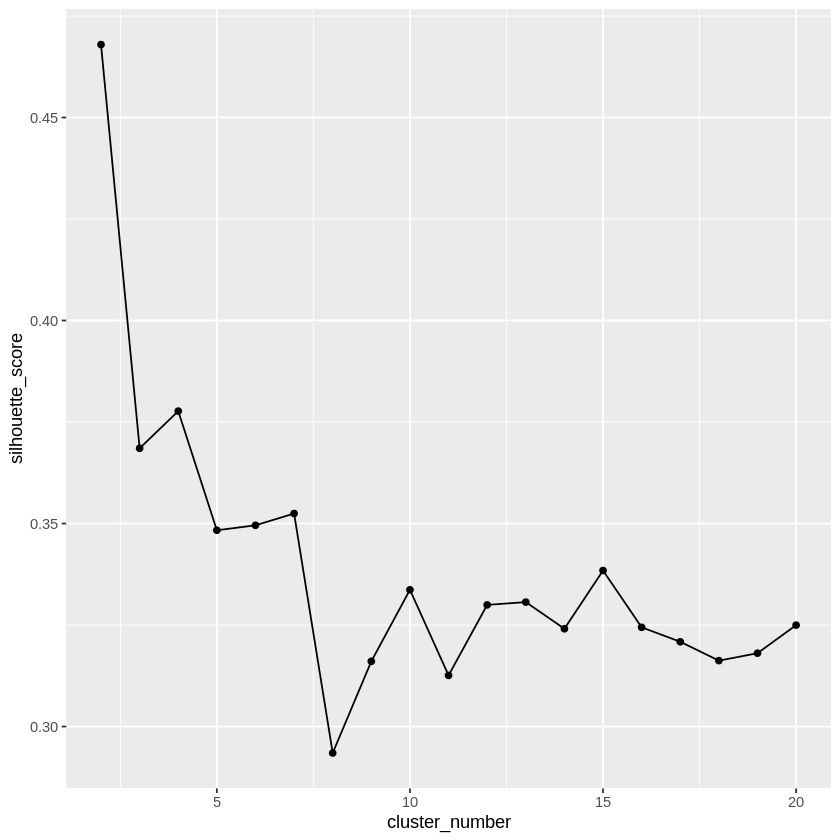

In [20]:
ggplot(model_statistics, aes(x = cluster_number, y = silhouette_score)) +
  geom_point() + geom_line()

Here, from looking at the silhouette scores, the optimal number of clusters is two.

### Step 4: Applying Hierarchical clustering

To apply hierarchical clustering, we use the function `hclust`, which is part of R's core functions, so there is no need to load other external libraries. Recall that the variable `distances` contains all the information about the distance between the movie raters. This is the only input one needs to feed into `hclust`. Actually, `hclust` also contains options, such as regarding how the distance between different clusters is calculated. These choices would also affect the final outcome. For now, let's use the default options, so there is no need to specify them in our code.

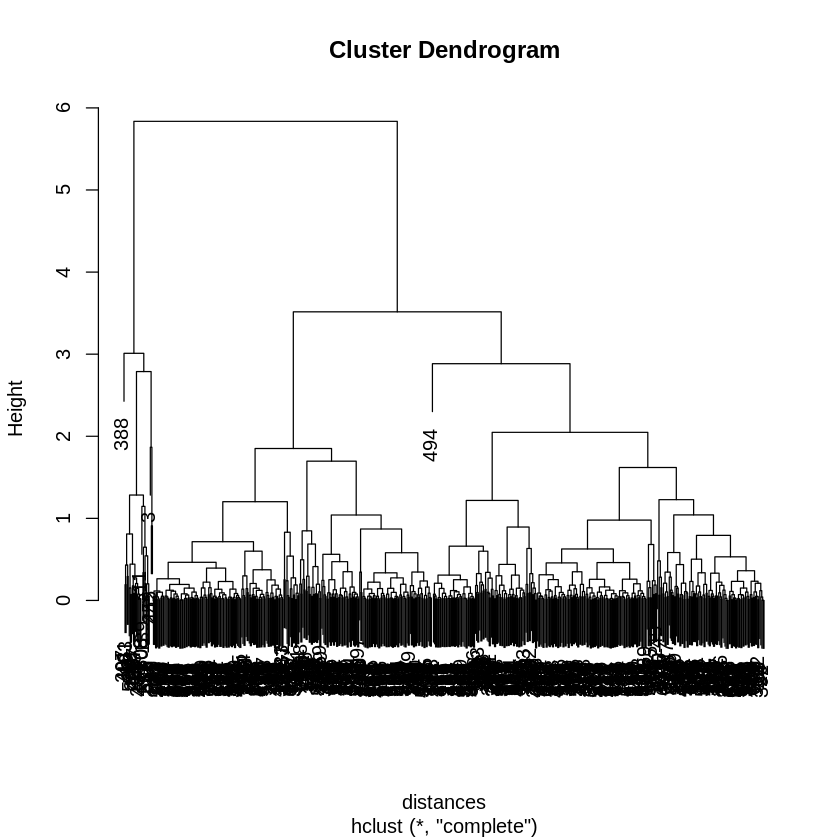

In [21]:
# apply hierarchical clustering
hc <- hclust(distances) 
# plot the dendrogram
plot(hc)

To form two clusters from this dendrogram, we use the  `cutree ` function, which has two inputs. The first one is the output from hierarchical clustering, while the second is the number of clusters required. We then plot the clusters as before. Compared to the output of k-means with  `k=2 `, we see that the overall interpretation remains, while the boundary between two clusters is shifted slightly towards zero.

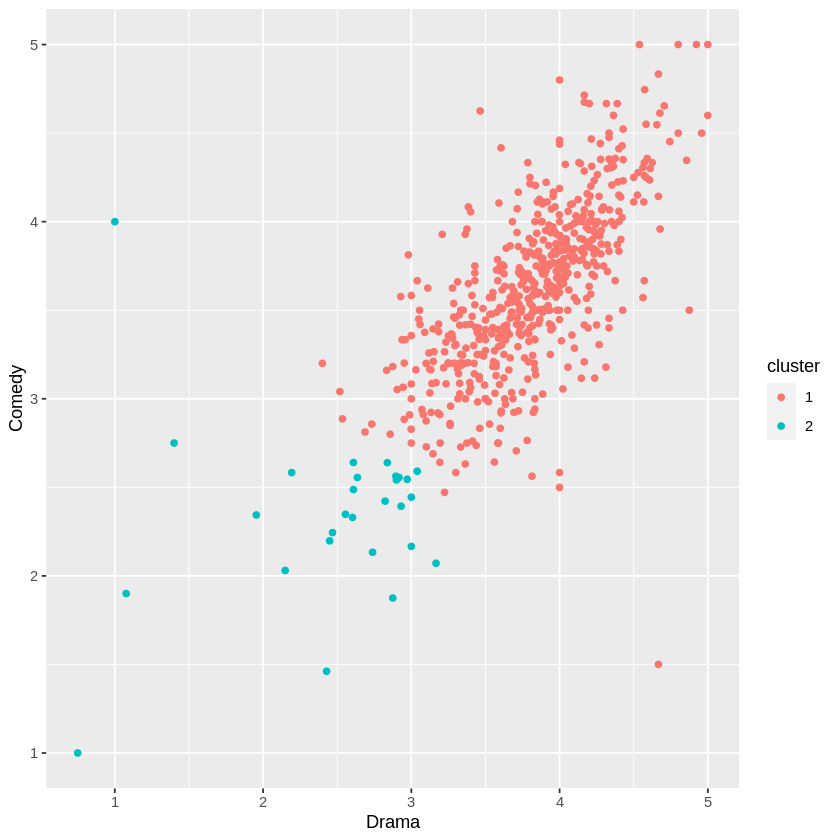

In [22]:
hcluster_2 <- cutree(hc, 2)
rsf_5 <- rsf_2[,]%>%
          mutate(cluster =  as.factor(hcluster_2))

ggplot(rsf_5) + geom_point(aes(x = Drama, y = Comedy, color = cluster))


Finally, let's form three clusters from the dendrogram and plot the results. We see that here, the output of hierarchical clustering with three clusters, and that of k-means with `k=3`, are quite similar to each other.

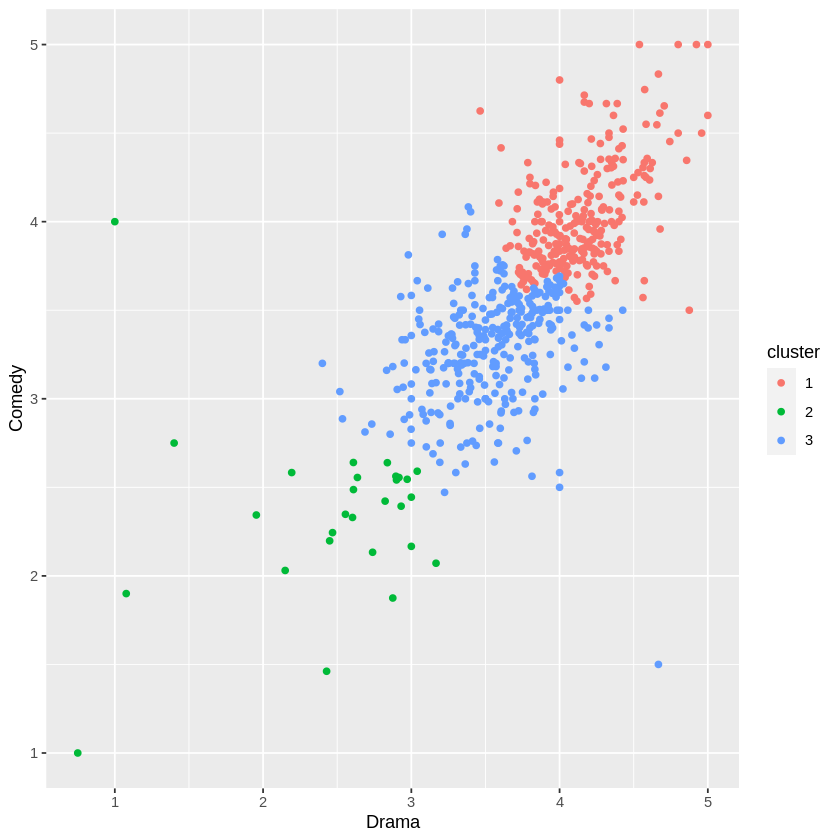

In [23]:
hcluster_3 <- cutree(hc, 3)
rsf_6 <- rsf_2[,]%>%
          mutate(cluster =  as.factor(hcluster_3))

ggplot(rsf_6) + geom_point(aes(x = Drama, y = Comedy, color = cluster))